# CAIM Lab Session 8: Betweenness centrality and community detection

In this session you will:

- familiarize yourself with the NetworkX graph library.
- implement Brandes's algorithm for betweenness centrality.
- implement the Girvan-Newman algorithm for community detection.
- evaluate the community structure using a ground truth and modularity metrics.

# 1. NetworkX

Networkx is a graph library that is very convenient to use in Python. 
(Being itself written in Python, it is not the most performant one on large graphs, though.)

In [205]:
import networkx as nx

G = nx.Graph() 
G.add_nodes_from(range(4))
G.add_edges_from([ (0, 0), (0, 2), (0, 3), (1, 0), (1, 3), (2, 1), (2, 3), (3, 1)])

# Print degrees. Note that self-loops are counted as two edges.
for v in G.nodes():
    print("Node:", v, "Degree:", G.degree(v))

for u, v in G.edges():
    print("Edge:", u, "-", v)
    
v = 2
print("Neighbors of", v, ":", list(G.neighbors(v)))

Node: 0 Degree: 5
Node: 1 Degree: 3
Node: 2 Degree: 3
Node: 3 Degree: 3
Edge: 0 - 0
Edge: 0 - 2
Edge: 0 - 3
Edge: 0 - 1
Edge: 1 - 3
Edge: 1 - 2
Edge: 2 - 3
Neighbors of 2 : [0, 1, 3]


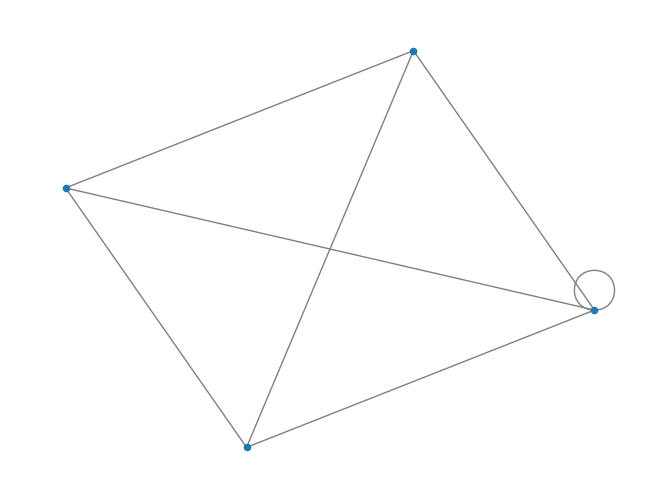

In [206]:
import matplotlib.pyplot as plt
nx.draw(G, nx.spring_layout(G), node_size=20, edge_color="gray")

# 2. Betweenness centrality
Betweenness centrality is a measure of centrality in a graph based on shortest paths.
It may be defined for vertices and for edges.
We will focus on edge-betweenness centrality, given by the expression
$$
    \text{bet}(e) = \sum_{\substack{s, t \in V \\ s \neq t}} \frac{\sigma_{st}(e)}{\sigma_{st}},
$$
where 
  
- $\sigma_{st} = $ number of shortest paths from $s$ to $t$
- $\sigma_{st}(e) = $ number of shortest paths from $s$ to $t$ using edge $e$

Below is a brute-force implementation to compute it on the (very small) Zachary's karate club dataset:

In [207]:
def normalize_edge(pair):
    return (min(pair), max(pair))    

def slow_edge_betweenness(G):
    """    
    For each ordered pair (s,t), count the fraction of shortest paths that use each edge by explicit enumeration.
    Returns a dictionary {(u,v): betweenness}.
    
    Very slow! Only for educational purposes.
    """
    bet = {normalize_edge(e): 0.0 for e in G.edges()}
    nodes = G.nodes()
    for s in nodes:
        for t in nodes:
            if s != t:                
                try:
                    paths = list(nx.all_shortest_paths(G, source=s, target=t))
                except nx.NetworkXNoPath:
                    continue
                    
                total = len(paths)
                for p in paths:                
                    for i in range(len(p) - 1):                                        
                        bet[normalize_edge((p[i], p[i + 1]))] += 1.0 / total

    return bet

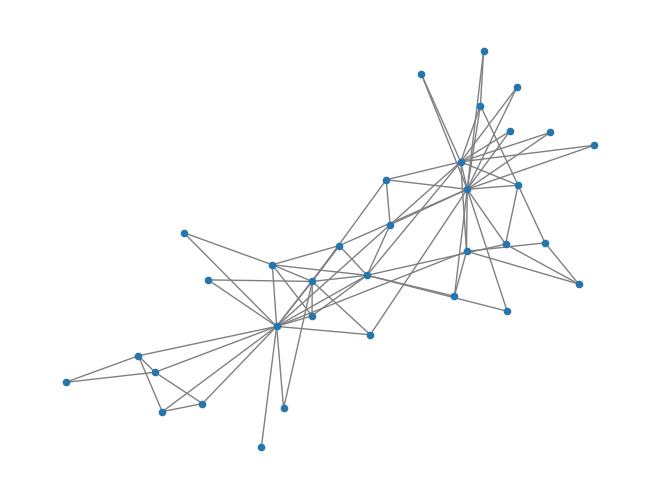

In [208]:
G = nx.karate_club_graph()
nx.draw(G, nx.spring_layout(G), node_size=20, edge_color="gray")

Note that for undirected graphs, some libraries like NetworkX normalize centrality by a factor of 2 as a convention to avoid counting an edge in both directions.

In [209]:
bet_slow = slow_edge_betweenness(G)
bet_nx = nx.edge_betweenness_centrality(G, normalized=False)

for e in map(normalize_edge, sorted(G.edges())):
    print(e, bet_slow[e], 2 * bet_nx[e])

(0, 1) 28.33333333333333 28.33333333333333
(0, 2) 87.27777777777781 87.27777777777777
(0, 3) 23.0 23.0
(0, 4) 58.666666666666806 58.666666666666664
(0, 5) 87.66666666666647 87.66666666666666
(0, 6) 87.66666666666649 87.66666666666667
(0, 7) 25.604761904761915 25.6047619047619
(0, 8) 83.29682539682558 83.29682539682543
(0, 10) 58.66666666666683 58.666666666666664
(0, 11) 66.00000000000021 66.0
(0, 12) 52.200000000000166 52.19999999999999
(0, 13) 47.54126984127002 47.54126984126986
(0, 17) 45.019047619047754 45.019047619047626
(0, 19) 51.54126984126998 51.54126984126985
(0, 21) 45.01904761904775 45.01904761904762
(0, 31) 142.78571428571405 142.78571428571425
(1, 2) 26.06666666666665 26.06666666666667
(1, 3) 8.666666666666666 8.666666666666666
(1, 7) 8.328571428571427 8.328571428571427
(1, 13) 13.919047619047621 13.919047619047621
(1, 17) 20.980952380952374 20.980952380952374
(1, 19) 16.419047619047618 16.419047619047618
(1, 21) 20.980952380952374 20.980952380952374
(1, 30) 36.21904761904

## Brandes's algorithm

The method above is rather slow, as there may be an exponential number of shortest paths between a given pair.
Fortunately, for every fixed source vertex $s$ one may obtain the shortest path DAG and use dynamic programming to compute all $\sigma_{st}$ and $\sigma_{st}(e)$ in polynomial time.

However, a naive implementation of this idea still leads to a prohibitively slow $\Omega(|V|^2 |E|)$ algorithm.
Brandes introduced a technique to reduce the runtime by aggregating all target contributions in a single dependency pass. His algorithm computes edge and/or vertex betweenness in time $O(|V| |E|)$ and space $O(|V| + |E|)$:

We start with a global array `bet[v, w]` (edge betweenness of (v, w), initialized to 0).
Now, for every source vertex $s$, do the following:

* **Step 1 – Calculation of shortest paths**  
  Perform a Breadth-First Search from $s$ to compute:
  - `dist[v]`: shortest-path distance from $s$ to $v$.
  - `pred[v]`: list of predecessors of node \(v\) on the shortest path DAG from the source node $s$.
  - $\sigma[v]$: number of shortest paths from $s$ to $v$.  
  

* **Step 2 – Dependency accumulation**  
  Iterate through nodes in order of reverse distance from $s$ (starting from the farthest one). We need an additional array:
  - $\delta[v]$: dependency value of node \(v\), initialized to 0. 
  
  For each predecessor $v$ of $w$, update dependency $\delta[v]$ and the total betweenness of $(v, w)$:

  $$
  \delta[v]  \gets \delta[v] + \frac{\sigma[v]}{\sigma[w]}\,\bigl(1+\delta[w]\bigr)
  $$

  and the contribution to the betweenness of edge $(v,w)$ is:

  $$
  \text{bet}(v,w) \gets \text{bet}(v, w) + \frac{\sigma[v]}{\sigma[w]} \,\bigl(1+\delta[w]\bigr).
  $$


---

**Exercise 1:**  
Complete the code below to implement Brandes's algorithm. Test its accuracy and performance on the `email-Eu-core` dataset from the next section.

In [13]:
from collections import deque, defaultdict

def edge_betweenness(G):
    """
    Compute betweenness centrality for edges using Brandes' algorithm.
    :param G: A NetworkX graph
    :return: Dictionary of edges with betweenness centrality as the value.
    """
    bet = defaultdict(float)
    V = G.nodes()

    for s in V:
        pred = {v: [] for v in V}
        sigma = {v: 0 for v in V}
        dist = {v: -1 for v in V}
        delta = {v: 0 for v in V}

        sigma[s] = 1
        dist[s]  = 0

        queue = deque([s])
        stack = []

        # Step 1: calculate dist, sigma, pred during BFS
        while queue:
            v = queue.popleft()
            # ...
            
        # Step 2: Dependency accumulation
        while stack:
            w = stack.pop()
            # ...
            
    return bet

# 2. Community detection using Girvan–Newman

In this section we implement a well-known hierarchical method for community detection in networks: the Girvan–Newman Algorithm. It is based on the intuition that in tightly connected communities with few edges across communities, all shortest paths between vertices in different communities must go through a small set of edges, so at least one of these edges must have high  betweenness. The process is the following:

* **Calculate Edge Betweenness**  for every edge.

* **Edge Removal**: iteratively remove the edge with the highest betweenness centrality until some component becomes disconnected. At this point, we obtained a finer partition.

* **Community Detection**  
  Continue the steps above until all nodes are isolated.
 
This process results in a sequence of partitions. Typically we use **modularity** to select the single best partition;  higher modularity typically indicates a better community structure.
We only record modularity and partitions when the number of connected components increases (i.e., the partition changes). Modularity is computed using the original graph.

  A formula to quickly compute the modularity $Q$ of a partition is
  $$ Q = \sum_{C} \left[ \frac{m_C}{m} - \left( \frac{K_C}{2m} \right)^2 \right] $$

where 
 * $m_C$ is the number of edges within community $C$, 
 * $K_C$ = sum of degrees of all nodes *in* $C$, and 
 * $m$ is the total number of edges.
 
 The trivial partition into one cluster always have modularity 0 and typically we don't need to record it.

## Dataset

We will use the email-Eu-core network from SNAP, a graph with 42 ground-truth clusters. We treat it as undirected and remove loops.

https://snap.stanford.edu/data/email-Eu-core.html

In [124]:
#!wget https://snap.stanford.edu/data/email-Eu-core.txt.gz && gunzip email-Eu-core.txt.gz
#!wget https://snap.stanford.edu/data/email-Eu-core-department-labels.txt.gz && gunzip email-Eu-core-department-labels.txt.gz

In [169]:
G = nx.read_edgelist("email-Eu-core.txt", nodetype=int)
G.remove_edges_from(nx.selfloop_edges(G))
print("Loaded graph:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")

Loaded graph: 1005 nodes, 16064 edges


Load the ground truth labels

In [170]:
with open("email-Eu-core-department-labels.txt") as f:
    ground_truth = dict([tuple(map(int, l.split())) for l in f.readlines()])
ground_communities = defaultdict(list)
for v, cluster_id in ground_truth.items():
    ground_communities[cluster_id].append(v)
print(len(ground_communities), "communities")    
print("Ground truth cluster sizes =", sorted([len(C) for C in ground_communities.values()], key = lambda x:-x))
print("Ground truth modularity =", compute_modularity(G, ground_communities.values()))

42 communities
Ground truth cluster sizes = [109, 92, 65, 61, 55, 51, 49, 39, 35, 32, 29, 29, 28, 27, 26, 25, 25, 22, 19, 18, 15, 14, 13, 13, 13, 12, 10, 10, 9, 9, 8, 8, 6, 6, 5, 4, 4, 3, 3, 2, 1, 1]
Ground truth modularity = 0.28801318862373715


Running Girvan-Newman on the full graph component is too slow in Python, so to speed up computations we sample a smaller connected subgraph that still preserves meaningful community structure.
In order to do so, we perform a certain kind of random walk of limited size that attempts to avoid repeating vertices, and consider only the subgraph induced by those nodes.

In [203]:
import numpy as np

def random_walk_sample(G, size, start=None):
    if start is None:
        start = np.random.choice(list(G.nodes()))
    sample = {start}
    current = start
    size = min(size, G.number_of_nodes())
    while len(sample) < size:
        neighbors = list(set(G.neighbors(current)) - sample)
        if not neighbors:
            current = np.random.choice(list(set(G.nodes()) - sample))
        else:
            current = np.random.choice(neighbors)
        sample.add(current)
    return sample

np.random.seed(4123814)
node_subset = random_walk_sample(G, size=250)
smallG = G.subgraph(node_subset).copy()
print("Induced subgraph:", smallG.number_of_nodes(), "nodes,", smallG.number_of_edges(), "edges")
smallG = G.subgraph(max(nx.connected_components(smallG), key=len)).copy()
assert len(list(nx.connected_components(smallG))) == 1

Induced subgraph: 250 nodes, 3523 edges


In [204]:
induced_ground_communities = defaultdict(list)
for v in smallG.nodes():
    induced_ground_communities[ground_truth[v]].append(v)
print("SmallG:", len(induced_ground_communities), "communities")    
print("Ground truth cluster sizes =", sorted([len(C) for C in induced_ground_communities.values()], key = lambda x:-x))
print("Ground truth modularity =", compute_modularity(smallG, induced_ground_communities.values()))

SmallG: 34 communities
Ground truth cluster sizes = [26, 22, 20, 18, 15, 13, 12, 12, 11, 11, 9, 7, 6, 6, 6, 6, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1]
Ground truth modularity = 0.19236864370215798


---

**Exercise 2:**  
Complete the code below to implement the Girvan-Newman algorithm and test in on `smallG`. Then:
- Track the modularity score at each iteration. How does it evolve as the algorithm progresses?
- Compare the Girvan-Newman algorithm with the Louvain algorithm (available in NetworkX) on the same dataset. Which one returns a higher-modularity clustering on this dataset?
- Compare the clusterings found by Girvan-Newman and Louvain with the ground truth and with via metrics such as number of clusters, precision/recall in terms of vertex pairs, and/or Adjusted Rand Index. (You may use, e.g., `adjusted_rand_score` from `sklearn.metrics`.)

In [ ]:
def compute_modularity(G_original, components):
    """
    Compute modularity for a partition (components) with respect to G_original.
    """
    m = G_original.number_of_edges()
    if m == 0: return 0

    # ...


def girvan_newman(G):
    """
    Implementation of the full Girvan-Newman Algorithm for community detection.    
    Returns:
        partitions: list of component lists
        modularities: list of modularity values
    """
    G0 = G                   # initial graph, for modularity computation
    G = G.copy()             # working graph    
    partitions = []
    modularities = []

    while G.number_of_edges() > 0:
        # Remove edge with the highest betweenness centrality
        e = # ...
        G.remove_edge(*e)
        
        # Get connected components (current set of communities)
        comps = list(nx.connected_components(G))
        
        # If the partition has changed, add it and its modularity score (w.r.t to the original graph)
        if not partitions or len(comps) > len(partitions[-1]):                    
            # ...

    return partitions, modularities

## 5. Rules of delivery

- To be solved in _pairs_.

- Submit the **report** as a PDF file. Make sure it has **both your names, date, and title**. Include your **code** in your submission (.py or .ipynb).

- No plagiarism; don't discuss your work with other teams. You can ask for help to others for simple things, such as recalling a python instruction or module, but nothing too specific to the session.

- If you feel you are spending much more time than the rest of the classmates, ask us for help. Questions can be asked either in person or by email, and you'll never be penalized by asking questions, no matter how stupid they look in retrospect.

- Write a short report listing the solutions to the exercises proposed. Include things like the important parts of your implementation (data structures used for representing objects, algorithms used, etc). You are welcome to add conclusions and findings that depart from what we asked you to do. We encourage you to discuss the difficulties you find; this lets us give you help and also improve the lab session for future editions.



- Submit your work through the [raco](http://www.fib.upc.edu/en/serveis/raco.html); see date at the raco's submissions page.